In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv('train.zip', compression='zip', header=0, sep=',', quotechar='"')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Мы видим информацию о каждой поездке. Нам известны координаты, время начала поездки, количество пассажиров и т.д. Удалим колонку, которая есть только в обучающей выборке `dropoff_datetime`. Из названия понятно, что используя эту колонку и `pickup_datetime` мы сможем восстановить длину поездки. Очевидно, что в начале поездки `dropoff_datetime` нам недоступна, а значит и для предсказания ее использовать нельзя.

In [ ]:
df = df.drop('dropoff_datetime', axis=1)

Сейчас даты записаны в виде строк. Давайте преобразуем их в  datetime объекты. Таким образом мы сможем выполнять арифметические операции с датами и вытаскивать нужную информацию, не работая со строками.

In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Давайте разобьем выборку на train и test. Применить функцию `train_test_split` в этот раз не получиться. Мы теперь имеем дело с временными данными и на практике наша модель должна уметь работать во временных периодах, которых нет в обучающей выборке. Поэтому разбивать мы будем датасет по хронологии. Для этого отсортируем датасет по дате и возьмем первые N строк.

In [ ]:
df = df.sort_values(by='pickup_datetime')

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736


In [ ]:
df_train = df[:10 ** 6]
df_test = df[10 ** 6:]

Напомню, что мы будем пресказывать переменную trip_duration. Посмотрим на target переменную.

<AxesSubplot:>

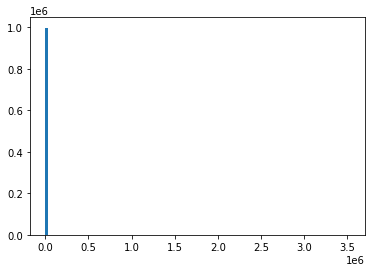

In [ ]:
df_train.trip_duration.hist(bins=100, grid=False, )

Что то пошло не так. Вероятно, есть очень длинные поездки и короткие. Попробуем взять `log(1 + x)` от длины поездки. Единицу мы прибавляем, чтобы избежать проблем с поездками, которые например мгновенно завершились. 

<AxesSubplot:>

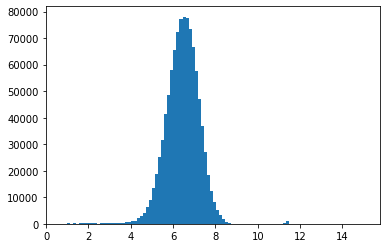

In [ ]:
import numpy as np
np.log1p(df_train.trip_duration).hist(bins=100, grid=False, )

Мы получили куда более ясную картину, распределение стало похоже на нормальное. Работать будем теперь с логарифмом. Так линейной регрессии будет куда проще выучить корректную зависимость. А если захотим вернуться к исходным данным, возведем предсказание в экспоненту.

In [ ]:
df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)

<ipython-input-10-05311ce01512>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['log_trip_duration'] = np.log1p(df_train.trip_duration)
<ipython-input-10-05311ce01512>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['log_trip_duration'] = np.log1p(df_test.trip_duration)


In [ ]:
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)

Посмотрим на наши признаки. Давайте нарисуем, как выглядит распределение количества поездок по дням.

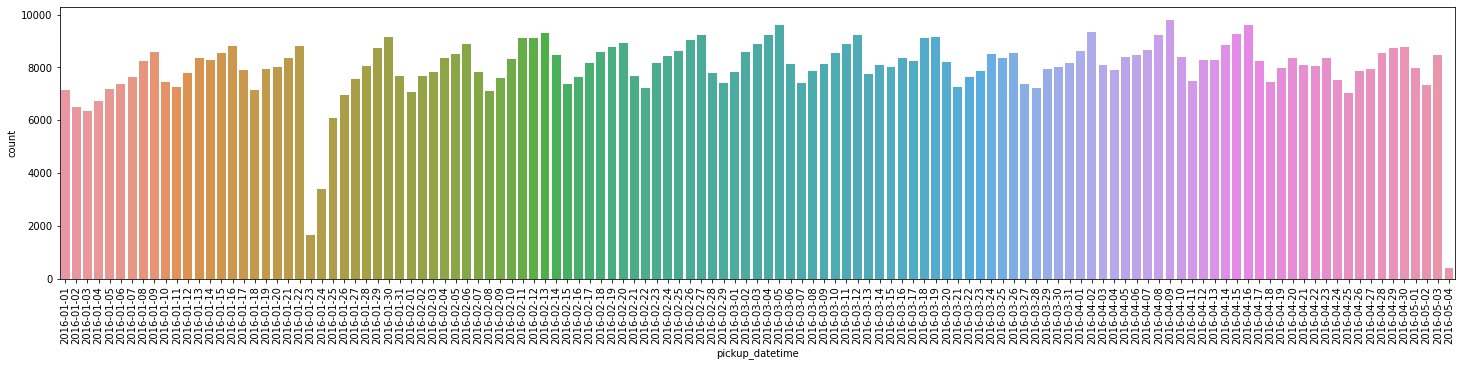

In [ ]:
date_sorted = df_train.pickup_datetime.apply(lambda x: x.date()).sort_values()

plt.figure(figsize=(25, 5))
date_count_plot = sns.countplot(
  x=date_sorted,
)
date_count_plot.set_xticklabels(date_count_plot.get_xticklabels(), rotation=90);

Мы можем увидеть паттерны, которые повторяются каждую неделю. Также мы можем наблюдать несколько аномальных правалов в количестве поездок. Посмотрим, как выглядит распределение по часам.

/Users/vsb/.virtualenvs/science/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pickup_datetime', ylabel='count'>

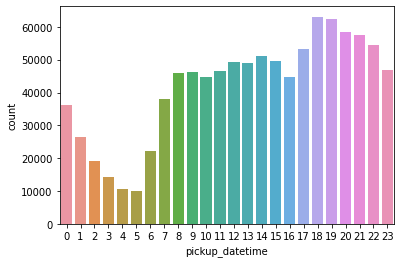

In [ ]:
sns.countplot(
  df_train.pickup_datetime.apply(lambda x: x.hour),
)

Теперь давайте посмотрим, как связан день и длина поездки.

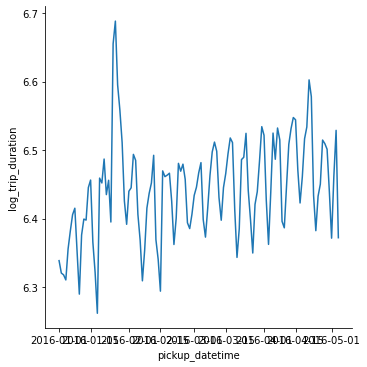

In [ ]:
group_by_weekday = df_train.groupby(df_train.pickup_datetime.apply(lambda x: x.date()))
sns.relplot(data=group_by_weekday.log_trip_duration.aggregate('mean'), kind='line');

Мы видим явный тренд. Более того, наблюдается такая вещь как сезонность: повторяющиеся временные паттерны. В нашем случае период равен неделе.

Теперь подготовим датасет. Включим в него день года и час дня. Для этого напишем функцию `add`, которая будет собирать нам нужные признаки в отдельный `pandas.DataFrame`. В итоге, мы сможем воспользоваться этой функцией, как для train подвыборки, так и для test.

In [ ]:
import datetime
def add(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
     ], axis=1, keys=['day', 'hour',]
  )
  
  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = add(df_train)
X_test, y_test = add(df_test)

In [ ]:
X_train.head()

,day,hour
96469,1,0
223872,1,0
713067,1,0
652463,1,0
722901,1,0


Переменная час, хоть и является целым числом, не может трактоваться как вещественная. Дело в том, что после 23 идет 0, и что будет означать коэффициент регрессии в таком случае, совсем не ясно. Поэтому применим к этой переменной one -hot кодирование. В тоже время, переменная день должна остаться вещественной, так как значения из обучающей выборки не встречаются нам на тестовом подмножестве.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 

In [ ]:
ohe = ColumnTransformer([("One hot", OneHotEncoder(sparse=False),[1])], remainder="passthrough")

In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

Воспользуемся классом `Ridge` и обучим модель.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [ ]:
ridge = Ridge(alpha=1000).fit(X_train, y_train)

In [ ]:
mean_squared_error(ridge.predict(X_test), y_test)

0.6539687819760848

Давайте попробуем сделать лучше и подберем гиперпараметры модели.

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_searcher = GridSearchCV(Ridge(),
                             param_grid={'alpha': np.linspace(100, 750, 10)},
                             cv=5).fit(X_train, y_train)

In [ ]:
mean_squared_error(grid_searcher.predict(X_test), y_test)

0.6538784861219816

In [ ]:
grid_searcher.best_params_

{'alpha': 388.8888888888889}

# Задание 1
Постройте график соответствующий количеству поездок в зависимости от дня недели по обучающей выборке. 


In [ ]:
df_train = df_train.assign(
    pickup_weekday=df_train.apply(lambda row: row.pickup_datetime.weekday() + 1, axis=1)
)
df_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_weekday
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849,6.745236,5
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,7.166266,5
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408,6.013715,5
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280,5.638355,5
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736,6.602588,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1384418,id2351670,2,2016-05-04 03:10:19,1,-73.990578,40.757702,-73.920914,40.756573,N,841,6.735780,3
1100978,id0756776,1,2016-05-04 03:11:21,1,-73.994774,40.760296,-73.984291,40.766556,N,137,4.927254,3
630885,id1074885,1,2016-05-04 03:11:36,1,-73.986427,40.741432,-73.895416,40.758724,N,1002,6.910751,3
567651,id1753963,2,2016-05-04 03:13:35,5,-73.994522,40.724815,-73.990700,40.723518,N,189,5.247024,3


<AxesSubplot:xlabel='pickup_weekday', ylabel='count'>

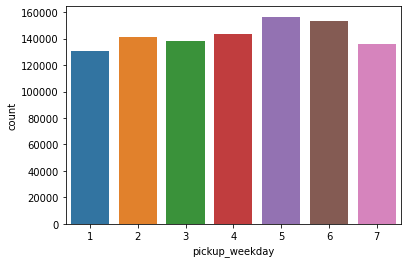

In [ ]:
sns.countplot(x='pickup_weekday', data=df_train)

# Задание 2
Добавьте к признакам бинарную переменную, которая равна 1 для двух аномальных дней и 0 во все остальные дни.
Для этого вам понадобиться модифицировать функцию `add`.

In [ ]:
abnormal_dates = set([datetime.date(2016, 1, 23), datetime.date(2016, 5, 4)])

In [ ]:
df_train = df_train.assign(
    is_anomaly=df_train.apply(lambda row: row.pickup_datetime.date() in abnormal_dates, axis=1)
)
df_train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,pickup_weekday,is_anomaly
96469,id0190469,2,2016-01-01 00:00:17,5,-73.981743,40.719158,-73.938828,40.829182,N,849,6.745236,5,False
223872,id1665586,1,2016-01-01 00:00:53,1,-73.985085,40.747166,-73.958038,40.717491,N,1294,7.166266,5,False
713067,id1210365,2,2016-01-01 00:01:01,5,-73.965279,40.801041,-73.947479,40.815170,N,408,6.013715,5,False
652463,id3888279,1,2016-01-01 00:01:14,1,-73.982292,40.751331,-73.991341,40.750340,N,280,5.638355,5,False
722901,id0924227,1,2016-01-01 00:01:20,1,-73.970108,40.759800,-73.989357,40.742989,N,736,6.602588,5,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384418,id2351670,2,2016-05-04 03:10:19,1,-73.990578,40.757702,-73.920914,40.756573,N,841,6.735780,3,True
1100978,id0756776,1,2016-05-04 03:11:21,1,-73.994774,40.760296,-73.984291,40.766556,N,137,4.927254,3,True
630885,id1074885,1,2016-05-04 03:11:36,1,-73.986427,40.741432,-73.895416,40.758724,N,1002,6.910751,3,True
567651,id1753963,2,2016-05-04 03:13:35,5,-73.994522,40.724815,-73.990700,40.723518,N,189,5.247024,3,True


# Задание 3
1. Добавьте день недели в качестве признака для обучения. Удобнее всего - модифицировать функцию `add`.

2. Заново проведите one-hot кодирование. Сколько признаков у вас получилось?

In [ ]:
import datetime
def add(data_frame):
  X = pd.concat([
      data_frame.pickup_datetime.apply(lambda x: x.timetuple().tm_yday),
      data_frame.pickup_datetime.apply(lambda x: x.hour),
      data_frame.pickup_datetime.apply(lambda x: x.weekday() + 1),
     ], axis=1, keys=['day', 'hour', 'weekday']
  )
  
  return X, data_frame.log_trip_duration

In [ ]:
X_train, y_train = add(df_train)
X_test, y_test = add(df_test)

In [ ]:
X_train.head()

,day,hour,weekday
96469,1,0,5
223872,1,0,5
713067,1,0,5
652463,1,0,5
722901,1,0,5


In [ ]:
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [ ]:
X_train, X_test

(array([[  1.,   0.,   0., ...,   0.,   1.,   5.],
        [  1.,   0.,   0., ...,   0.,   1.,   5.],
        [  1.,   0.,   0., ...,   0.,   1.,   5.],
        ...,
        [  0.,   0.,   0., ...,   0., 125.,   3.],
        [  0.,   0.,   0., ...,   0., 125.,   3.],
        [  0.,   0.,   0., ...,   0., 125.,   3.]]),
 array([[  0.,   0.,   0., ...,   0., 125.,   3.],
        [  0.,   0.,   0., ...,   0., 125.,   3.],
        [  0.,   0.,   0., ...,   0., 125.,   3.],
        ...,
        [  0.,   0.,   0., ...,   1., 182.,   4.],
        [  0.,   0.,   0., ...,   1., 182.,   4.],
        [  0.,   0.,   0., ...,   1., 182.,   4.]]))

In [ ]:
len(X_train[0])

26

# Задание 4

1. Отмасштабируйте единственный вещественный признак.
2. Обучите на полученных данных Lasso регрессию, в качества параметра  `alpha` возьмите 2.65e-05.

Какое качество в терминах MSE вы получили?

Сколько признаков было отобрано? В качестве критерия зануления признака используйте сравнение с $10^{-6}$ (с точностью до 3 знаков после запятой).

In [ ]:
df_train.head()
X_train[:, -2] = X_train[:, -2] / X_train[:, -2].max()
X_test[:, -2] = X_test[:, -2] / X_test[:, -2].max()

NameError: ignored

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=2.65 * (10 ** -5)).fit(X_train, y_train)

In [ ]:
mean_squared_error(lasso.predict(X_test), y_test)

0.6548580804084453

In [ ]:
filter_ = []
for coef in lasso.coef_:
    if round(coef, 3) < round(10 ** -6, 3):
        filter_.append(False)
    else:
        filter_.append(True)
        
filtered_coef_ = lasso.coef_[filter_]
filtered_coef_

array([0.01006503, 0.01311831, 0.04237458, 0.04535247, 0.06066331,
       0.08539776, 0.09120166, 0.06177117, 0.05853422, 0.03242561,
       0.        , 0.00246526, 0.09487659])

In [ ]:
len(filtered_coef_)

13